In [1]:
from cot_probing.activations import Activations
from cot_probing.eval import EvalResults, EvalQuestion
from cot_probing.typing import *
from fancy_einsum import einsum
import matplotlib.pyplot as plt

import pickle
import torch
import random

with open(
    # "../hf_results/activations_google--gemma-2-9b_ruin_names_S0_N300.pkl", "rb"
    "../hf_results/activations_google--gemma-2-9b_snarks_S0_N151.pkl",
    "rb",
) as f:
    activations: Activations = pickle.load(f)
print(activations.layers)
with open(
    # "../hf_results/eval_google--gemma-2-9b_ruin_names_S0_N300.pkl", "rb"
    "../hf_results/eval_google--gemma-2-9b_snarks_S0_N151.pkl",
    "rb",
) as f:
    eval_results: EvalResults = pickle.load(f)
print(eval_results)
questions = eval_results.questions
question0: EvalQuestion = questions[0]
question0

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
EvalResults(model_name=google/gemma-2-9b, task_name=snarks, seed=0, num_samples=151, 121 questions)


EvalQuestion(3292 tokens, locs keys = ['response'], is_correct=True, answer_char=B)

In [2]:
# check if locations correspond to the same tokens in every question
def check_locs_same_tokens():
    question0_locs = activations.activations_by_question[0].sorted_locs
    question0_locs_tokens = [question0.tokens[loc] for loc in question0_locs]
    ret = True
    for q_idx in range(1, len(questions)):
        question: EvalQuestion = questions[q_idx]
        question_locs = activations.activations_by_question[q_idx].sorted_locs
        question_locs_tokens = [question.tokens[loc] for loc in question_locs]
        if question_locs_tokens != question0_locs_tokens:
            print(
                f"Question {q_idx} locations point to different tokens: {question_locs_tokens}"
            )
            ret = False
    return ret


assert check_locs_same_tokens()

In [3]:
correct_idxs: list[int] = [
    q_idx for q_idx, q in enumerate(eval_results.questions) if q.is_correct
]
incorrect_idxs: list[int] = [
    q_idx for q_idx, q in enumerate(eval_results.questions) if not q.is_correct
]
print(f"Correct: {len(correct_idxs)}")
print(f"Incorrect: {len(incorrect_idxs)}")

Correct: 40
Incorrect: 81


In [4]:
random.seed(0)
TEST_SPLIT = 0.2
test_correct_idxs = random.sample(correct_idxs, k=int(len(correct_idxs) * TEST_SPLIT))
test_incorrect_idxs = random.sample(
    incorrect_idxs, k=int(len(incorrect_idxs) * TEST_SPLIT)
)
train_correct_idxs = [q_idx for q_idx in correct_idxs if q_idx not in test_correct_idxs]
train_incorrect_idxs = [
    q_idx for q_idx in incorrect_idxs if q_idx not in test_incorrect_idxs
]
print(f"Test Correct: {len(test_correct_idxs)}")
print(f"Test Incorrect: {len(test_incorrect_idxs)}")
print(f"Train Correct: {len(train_correct_idxs)}")
print(f"Train Incorrect: {len(train_incorrect_idxs)}")

Test Correct: 8
Test Incorrect: 16
Train Correct: 32
Train Incorrect: 65


In [5]:
# shape is (num_qs, num_layers, num_locs, d_model)
all_acts_by_q = torch.stack(
    [act.activations for act in activations.activations_by_question]
)
all_acts_by_q.shape

torch.Size([121, 42, 10, 3584])

In [6]:
def get_mean_acts(idxs: list[int]) -> Float[torch.Tensor, " layers locs model"]:
    # each one is shape (num_layers, num_locs, d_model)
    acts_by_q = all_acts_by_q[idxs]
    # mean over questions
    return acts_by_q.mean(dim=0)


correct_mean_acts = get_mean_acts(train_correct_idxs)
incorrect_mean_acts = get_mean_acts(train_incorrect_idxs)
probe = correct_mean_acts - incorrect_mean_acts
probe.shape

torch.Size([42, 10, 3584])

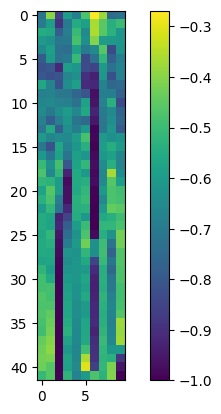

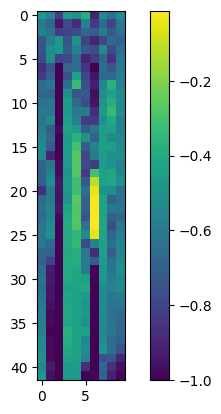

In [18]:
def get_probe_acts(idxs: list[int]) -> Float[torch.Tensor, " qs layers locs"]:
    acts_by_q = all_acts_by_q[idxs]
    return einsum(
        "qs layers locs model, layers locs model -> qs layers locs", acts_by_q, probe
    )


def calculate_normalized_margin(correct_idxs, incorrect_idxs):
    correct_probe_acts = get_probe_acts(correct_idxs)
    incorrect_probe_acts = get_probe_acts(incorrect_idxs)

    min_correct_probe_acts = correct_probe_acts.min(dim=0).values
    max_correct_probe_acts = correct_probe_acts.max(dim=0).values
    min_incorrect_probe_acts = incorrect_probe_acts.min(dim=0).values
    max_incorrect_probe_acts = incorrect_probe_acts.max(dim=0).values

    min_probe_acts = torch.minimum(min_correct_probe_acts, min_incorrect_probe_acts)
    max_probe_acts = torch.maximum(max_correct_probe_acts, max_incorrect_probe_acts)

    mean_correct_probe_acts = correct_probe_acts.mean(dim=0)
    mean_incorrect_probe_acts = incorrect_probe_acts.mean(dim=0)

    # margin = mean_correct_probe_acts - mean_incorrect_probe_acts
    margin = min_correct_probe_acts - max_incorrect_probe_acts
    normalized_margin = margin / (max_probe_acts - min_probe_acts)

    return normalized_margin


train_normalized_margin = calculate_normalized_margin(
    train_correct_idxs, train_incorrect_idxs
)
plt.imshow(train_normalized_margin)
plt.colorbar()
plt.show()
plt.close()

test_normalized_margin = calculate_normalized_margin(
    test_correct_idxs, test_incorrect_idxs
)
plt.imshow(test_normalized_margin)
plt.colorbar()
plt.show()
plt.close()

tensor(0.2949)


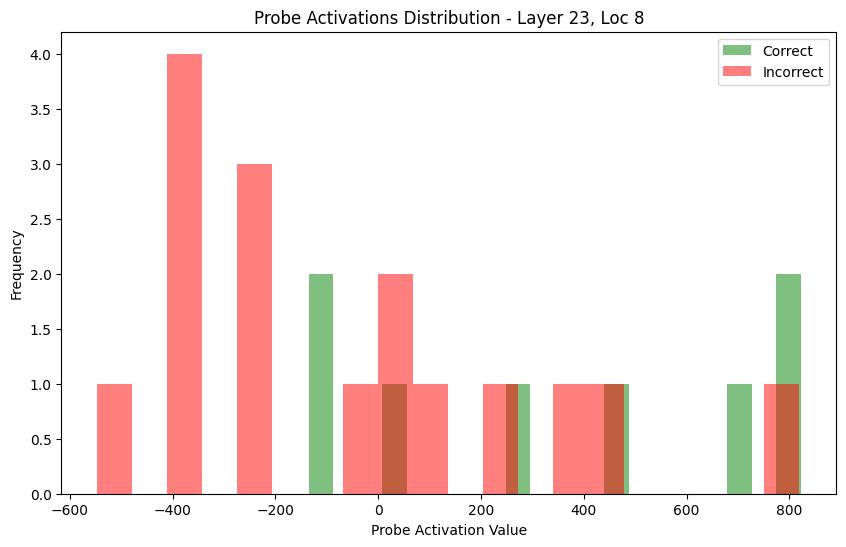

['-135.558', '-88.047', '51.832', '275.326', '467.806', '688.917', '783.605', '822.599']
['-548.158', '-406.915', '-379.002', '-350.500', '-350.011', '-249.657', '-216.198', '-215.965', '-65.392', '44.043', '51.162', '85.957', '236.725', '383.028', '426.744', '819.373']


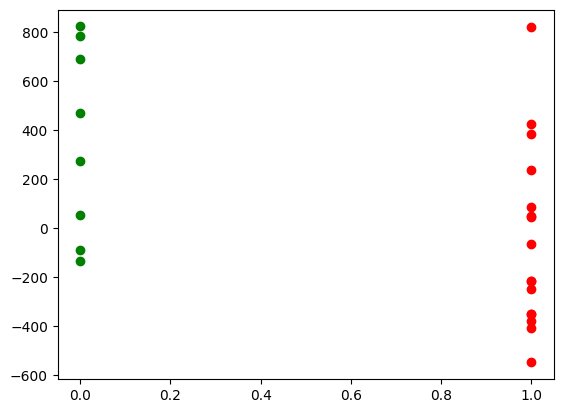

In [12]:
layer = 23
loc = 8
print(train_normalized_margin[layer, loc])
this_correct_acts = test_correct_probe_acts[:, layer, loc]
this_incorrect_acts = test_incorrect_probe_acts[:, layer, loc]
plt.figure(figsize=(10, 6))
plt.hist(this_correct_acts, bins=20, alpha=0.5, color="green", label="Correct")
plt.hist(this_incorrect_acts, bins=20, alpha=0.5, color="red", label="Incorrect")
plt.title(f"Probe Activations Distribution - Layer {layer}, Loc {loc}")
plt.xlabel("Probe Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.scatter([0] * len(this_correct_acts), this_correct_acts, color="green")
plt.scatter([1] * len(this_incorrect_acts), this_incorrect_acts, color="red")
print([f"{x:.3f}" for x in sorted(this_correct_acts.tolist())])
print([f"{x:.3f}" for x in sorted(this_incorrect_acts.tolist())])

In [9]:
margin.max(1)

torch.return_types.max(
values=tensor([9.0566e-02, 1.1969e-01, 4.4955e-01, 3.6812e+00, 3.9506e+00, 1.5198e+00,
        3.4351e-01, 3.8548e-01, 1.0299e+00, 1.7179e+00, 3.8582e+00, 1.0849e+02,
        2.2464e+02, 1.4939e+03, 1.6477e+03, 4.2437e+03, 1.7847e+03, 1.1477e+02,
        9.5521e+02, 4.2286e+03, 7.1942e+03, 8.0715e+03, 8.6093e+03, 8.3724e+03,
        4.4323e+03, 1.2989e+03, 5.6024e+02, 5.0893e+02, 6.8161e+02, 7.5625e+02,
        8.0111e+02, 7.7078e+02, 7.6870e+02, 8.1755e+02, 8.3583e+02, 9.2772e+02,
        9.2485e+02, 8.9456e+02, 7.2061e+02, 5.8763e+02, 4.9475e+02, 4.8975e+02]),
indices=tensor([5, 5, 2, 2, 2, 2, 9, 4, 0, 8, 1, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6,
        6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))